This notebook has the following changes compared to "test_tone_task_v1.nb"

1. Frequencies are distributed with a 20*log(1003/1000) difference in the log domain. 


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pdb
from scipy.optimize import minimize
from scipy.stats import multivariate_normal
from tqdm.notebook import tqdm
import random

In [2]:
def gaussian(x, mean, sigma):
    return np.exp(-(x-mean)**2/(2*sigma**2))

def posterior_array(log_freq_percept, n_tones, p_back, p_low, 
                    log_prior_low, log_prior_high):
    """
    Arguments: 
    log_freq_percept - range of all possible frequencies (percepts?)
    p_back - prob of background, p_low - prob of low condition
    log_prior_low - gaussian of low condition
    log_prior_high - gaussian of high condition
    """
    
    log_prior_low_mean = log_prior_low[0]; log_prior_low_sigma = log_prior_low[1];
    log_prior_high_mean = log_prior_high[0]; log_prior_high_sigma = log_prior_high[1];
    prior_low = gaussian(x=log_freq_percept, mean=log_prior_low_mean, sigma=log_prior_low_sigma)
    prior_high = gaussian(x=log_freq_percept, mean=log_prior_high_mean, sigma=log_prior_high_sigma)
    prior_dist_mixed_high = p_back*(1/len(log_freq_percept)) + (1-p_back)*prior_high \
    #mixture model with p(T|B) = 1/no. of possible freqs
    prior_dist_mixed_high /= prior_dist_mixed_high.sum() #normalizing
    prior_dist_mixed_high = np.expand_dims(prior_dist_mixed_high, axis = 1)
    prior_dist_mixed_low = p_back*(1/len(log_freq_percept)) + (1-p_back)*prior_low \
    #mixture model with p(T|B) = 1/no. of possible freqs
    prior_dist_mixed_low /= prior_dist_mixed_low.sum() #normalizing
    prior_dist_mixed_low = np.expand_dims(prior_dist_mixed_low, axis = 1)
    
    if n_tones == 3:
        prior_tones_low = np.expand_dims(prior_dist_mixed_low@np.transpose\
                                         (prior_dist_mixed_low),axis=2)@np.transpose(prior_dist_mixed_low) \
        #p(T1,T2..|L) 
        prior_tones_high = np.expand_dims(prior_dist_mixed_high@np.transpose\
                                          (prior_dist_mixed_high),axis=2)@np.transpose(prior_dist_mixed_high) \
        #p(T1,T2..|H) 
    elif n_tones == 2:
        prior_tones_low = prior_dist_mixed_low@np.transpose(prior_dist_mixed_low)
        prior_tones_high = prior_dist_mixed_high@np.transpose(prior_dist_mixed_high)
        
    elif n_tones == 1:
        prior_tones_low = prior_dist_mixed_low
        prior_tones_high = prior_dist_mixed_high
        
    normalizer = (1-p_low)*prior_tones_high + p_low*prior_tones_low #p(H)*p(T1,T2..|H) + p(L)*p(T1,T2..|L)
    posterior = prior_tones_high*(1-p_low)/normalizer
    # posterior /= np.sum(posterior)
    
    return prior_dist_mixed_high, prior_dist_mixed_low, posterior

In [3]:
# experimental task
def task(freq_seq, n_trials = 10, n_tones = 3, p_low = 0.5, p_back = 0.3):
    log_freq_seq_array = np.arange(np.log10(freq_seq[0]), np.log10(freq_seq[-1]), np.log10(1003/1000)*40)
    log_freq_seq_mid = np.median(log_freq_seq_array)
    log_freq_low = [log_freq_seq_mid - 0.2,0.1]  #low freq condition is gaussian 
    log_freq_high = [log_freq_seq_mid + 0.2,0.1] #high freq condition is gaussian
    trial_tones = []
    dist_chosen = []
    kind_of_tones = []

    for trial in range(n_trials):
        signal_rand = np.random.random()
        low_dist = signal_rand < p_low #choosing true tone from either low or high condition
        tones = []
        tone_kind = []
        for n_tone in range(n_tones):
            signal_back = np.random.random()
            background = signal_back < p_back #choosing background or true tone
            if background:
                if np.random.random() < 0.5:                    
                    nearest_log_tone = \
                    np.random.choice(log_freq_seq_array[0:np.argmin(np.abs(log_freq_seq_array -\
                                                        (log_freq_low[0]-0*log_freq_low[1])))])
                else:
                    nearest_log_tone = \
                    np.random.choice(log_freq_seq_array[np.argmin(np.abs(log_freq_seq_array -\
                                                        (log_freq_high[0]+0*log_freq_high[1]))):-1])
                #background freq is chosen from a uniform distribution
                tone_kind.append('b')
            else: 
                if low_dist:
                    tone = min(max(np.random.randn()*log_freq_low[1] + log_freq_low[0],\
                                   log_freq_seq_array[0]),log_freq_seq_array[-1])                    
                    tone_kind.append('l')
                else:
                    tone = min(max(np.random.randn()*log_freq_high[1] + log_freq_high[0],\
                                   log_freq_seq_array[0]),log_freq_seq_array[-1])
                    tone_kind.append('h')
                nearest_log_tone = log_freq_seq_array[np.argmin(np.abs(log_freq_seq_array - tone))]
            nearest_tone = freq_seq[np.argmin(np.abs(freq_seq - 10**nearest_log_tone))]        
            tones.append(nearest_tone)
        trial_tones.append(tones)
        dist_chosen.append(low_dist)
        kind_of_tones.append(tone_kind)
    return trial_tones, dist_chosen, kind_of_tones, log_freq_low, log_freq_high

In [4]:
# Given only one true tone
"""
Sample experiment
"""
expt_tones = np.arange(100,2000,1) #array of possible true tones
trial_tones, dist_chosen, kind_of_tones, log_freq_low, log_freq_high \
= task(freq_seq = expt_tones, n_trials = 150, n_tones = 1)

"""
Following code helps with understanding how many background tones are being sampled. 
"""
background_tone_cnt = np.zeros((len(trial_tones),1))
for i_trial in range(len(trial_tones)):
    background_tone_cnt[i_trial] = kind_of_tones[i_trial].count('b')
num_difficult_tones = np.sum(background_tone_cnt > 1)

old_difficult_tones_idxs = np.where(background_tone_cnt > 1)[0][:]
old_simple_tones_idxs = np.where(background_tone_cnt < 2)[0][:]

if (np.diff(old_difficult_tones_idxs)<2).any():
    new_difficult_tones_idxs = \
    [2*i + x \
     for i, x \
     in enumerate(sorted(random.sample(range(2*num_difficult_tones), num_difficult_tones)))]
    new_simple_tones_idxs = np.delete(np.arange(len(trial_tones)),new_difficult_tones_idxs)
    new_testing_trials = np.zeros_like(trial_tones)   
    new_testing_trials[new_difficult_tones_idxs] = np.array(trial_tones)[old_difficult_tones_idxs]
    new_testing_trials[new_simple_tones_idxs] = np.array(trial_tones)[old_simple_tones_idxs]
    new_dist_chosen = np.zeros_like(dist_chosen)
    new_dist_chosen[new_difficult_tones_idxs] = np.array(dist_chosen)[old_difficult_tones_idxs]
    new_dist_chosen[new_simple_tones_idxs] = np.array(dist_chosen)[old_simple_tones_idxs]
    new_kind_of_tones = np.zeros_like(kind_of_tones)
    new_kind_of_tones[new_difficult_tones_idxs] = np.array(kind_of_tones)[old_difficult_tones_idxs]
    new_kind_of_tones[new_simple_tones_idxs] = np.array(kind_of_tones)[old_simple_tones_idxs]
    
    trial_tones = list(new_testing_trials)
    dist_chosen = list(new_dist_chosen)
    kind_of_tones = list(new_kind_of_tones)
    
print(sum(background_tone_cnt == 0), sum(background_tone_cnt == 1))
    

[102] [48]


In [7]:
# Given two tones
"""
Sample experiment
"""
expt_tones = np.arange(100,2000,1) #array of possible true tones
trial_tones, dist_chosen, kind_of_tones, log_freq_low, log_freq_high = \
task(freq_seq = expt_tones, n_trials = 100, n_tones = 2)

"""
Following code helps with understanding how many background tones are being sampled. 
"""
background_tone_cnt = np.zeros((len(trial_tones),1))
for i_trial in range(len(trial_tones)):
    background_tone_cnt[i_trial] = kind_of_tones[i_trial].count('b')
num_difficult_tones = np.sum(background_tone_cnt > 1)

old_difficult_tones_idxs = np.where(background_tone_cnt > 1)[0][:]
old_simple_tones_idxs = np.where(background_tone_cnt < 2)[0][:]

if (np.diff(old_difficult_tones_idxs)<2).any():
    new_difficult_tones_idxs = \
    [2*i + x \
     for i, x \
     in enumerate(sorted(random.sample(range(2*num_difficult_tones), num_difficult_tones)))]
    new_simple_tones_idxs = np.delete(np.arange(len(trial_tones)),new_difficult_tones_idxs)
    new_testing_trials = np.zeros_like(trial_tones)   
    new_testing_trials[new_difficult_tones_idxs] = np.array(trial_tones)[old_difficult_tones_idxs]
    new_testing_trials[new_simple_tones_idxs] = np.array(trial_tones)[old_simple_tones_idxs]
    new_dist_chosen = np.zeros_like(dist_chosen)
    new_dist_chosen[new_difficult_tones_idxs] = np.array(dist_chosen)[old_difficult_tones_idxs]
    new_dist_chosen[new_simple_tones_idxs] = np.array(dist_chosen)[old_simple_tones_idxs]
    new_kind_of_tones = np.zeros_like(kind_of_tones)
    new_kind_of_tones[new_difficult_tones_idxs] = np.array(kind_of_tones)[old_difficult_tones_idxs]
    new_kind_of_tones[new_simple_tones_idxs] = np.array(kind_of_tones)[old_simple_tones_idxs]
    
    trial_tones = list(new_testing_trials)
    dist_chosen = list(new_dist_chosen)
    kind_of_tones = list(new_kind_of_tones)
    
print(sum(background_tone_cnt == 0), sum(background_tone_cnt == 1), sum(background_tone_cnt == 2))

[51] [37] [12]


In [6]:
# Given three tones
"""
Sample experiment
"""
expt_tones = np.arange(100,2000,1) #array of possible true tones
trial_tones, dist_chosen, kind_of_tones, log_freq_low, log_freq_high = \
task(freq_seq = expt_tones, n_trials = 1000, n_tones = 3)

"""
Following code helps with understanding how many background tones are being sampled. 
"""
background_tone_cnt = np.zeros((len(trial_tones),1))
for i_trial in range(len(trial_tones)):
    background_tone_cnt[i_trial] = kind_of_tones[i_trial].count('b')
num_difficult_tones = np.sum(background_tone_cnt > 2)

old_difficult_tones_idxs = np.where(background_tone_cnt > 3)[0][:]
old_simple_tones_idxs = np.where(background_tone_cnt < 3)[0][:]

if (np.diff(old_difficult_tones_idxs)<2).any():
    new_difficult_tones_idxs = \
    [2*i + x \
     for i, x \
     in enumerate(sorted(random.sample(range(2*num_difficult_tones), num_difficult_tones)))]
    new_simple_tones_idxs = np.delete(np.arange(len(trial_tones)),new_difficult_tones_idxs)
    new_testing_trials = np.zeros_like(trial_tones)   
    new_testing_trials[new_difficult_tones_idxs] = np.array(trial_tones)[old_difficult_tones_idxs]
    new_testing_trials[new_simple_tones_idxs] = np.array(trial_tones)[old_simple_tones_idxs]
    new_dist_chosen = np.zeros_like(dist_chosen)
    new_dist_chosen[new_difficult_tones_idxs] = np.array(dist_chosen)[old_difficult_tones_idxs]
    new_dist_chosen[new_simple_tones_idxs] = np.array(dist_chosen)[old_simple_tones_idxs]
    new_kind_of_tones = np.zeros_like(kind_of_tones)
    new_kind_of_tones[new_difficult_tones_idxs] = np.array(kind_of_tones)[old_difficult_tones_idxs]
    new_kind_of_tones[new_simple_tones_idxs] = np.array(kind_of_tones)[old_simple_tones_idxs]
    
    trial_tones = list(new_testing_trials)
    dist_chosen = list(new_dist_chosen)
    kind_of_tones = list(new_kind_of_tones)
    
print(sum(background_tone_cnt == 0), sum(background_tone_cnt == 1), \
      sum(background_tone_cnt == 2), sum(background_tone_cnt == 3))

[208] [444] [302] [46]


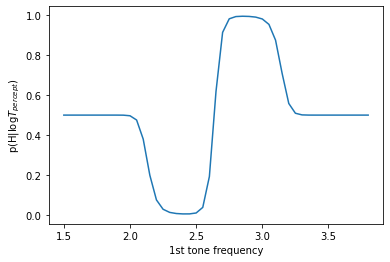

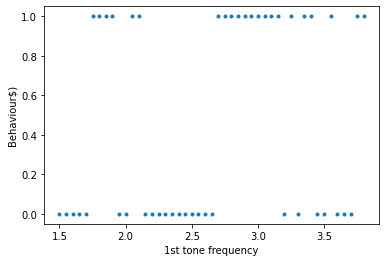

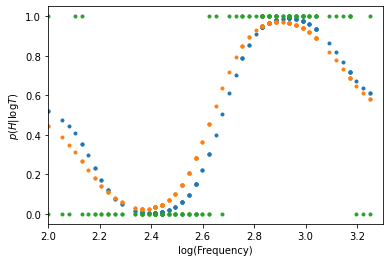

In [23]:
"""
One tone
Perceptual tones have a longer range than the experimental tones.
"""

log_freq_percept = np.arange(np.log10(expt_tones[0])-0.5, np.log10(expt_tones[-1])+0.5, 0.05) 

prior_dist_mixed_high, prior_dist_mixed_low, posterior = \
posterior_array(log_freq_percept, n_tones=1, p_back=0.2, p_low=0.5, \
               log_prior_low=log_freq_low, log_prior_high=log_freq_high)
            
plt.plot(log_freq_percept,posterior)
plt.xlabel('1st tone frequency')
plt.ylabel('p(H|$\log T_{percept}$)')
plt.show() 

"""
Given the true tones, derive the noisy perceptual distribution and compute the correponding observer's behaviour
Decision rule - the behaviour is 1 if p(H|log(T_{perc})) > 0.52 and 0 if p(H|log(T_{perc})) < 0.48. 
Otherwise we assume that the observer being imperfect has a 0.5 probability of choosing high or low. 
Probability_high - probability the observer will choose high given the true tone, p(B_H|log(T))
"""
probability_bhigh = np.zeros((len(trial_tones),1))
probability_high = np.zeros((len(trial_tones),1))
behaviour = (posterior >= 0.7)
for i_post in range(len(posterior)):
    if posterior[i_post] < 0.7 and posterior[i_post] > 0.3:
        behaviour[i_post] = np.random.random() < 0.5
plt.plot(log_freq_percept, behaviour,'.')
plt.xlabel('1st tone frequency')
plt.ylabel('Behaviour$)')
plt.show()         
        
for i_stim in range(len(trial_tones)):
    input_array = gaussian(log_freq_percept, mean = np.log10(trial_tones[i_stim]), sigma = 0.1)
    input_array /= np.sum(input_array)
    input_array = np.expand_dims(input_array, axis = 1)  
    """
    for i_post in range(len(posterior)):
        if posterior[i_post] < 0.53 and posterior[i_post] > 0.47:
            behaviour[i_post] = np.random.random() < 0.5
    """        
    probability_bhigh[i_stim] = np.transpose(behaviour)@input_array
    probability_high[i_stim] = np.transpose(posterior)@input_array

plt.plot(np.log10(trial_tones), probability_bhigh,'.') 
plt.plot(np.log10(trial_tones), probability_high,'.')
plt.xlim(np.log10(expt_tones[0]),np.log10(expt_tones[-1]))
plt.ylabel('$p(H|\log T)$')
plt.xlabel('log(Frequency)')

"""
For sample experiment, we choose the observer's behaviour based on p(B_H|\log T).
If p(B_H|\log T) > 0.55, H = 1, if less than < 0.45, H = 0. Else it is a coin toss. 
"""

trial_behaviour = probability_bhigh > 0.7
for i_prob in range(len(probability_bhigh)):
        if probability_bhigh[i_prob] > 0.3 and probability_bhigh[i_prob] < 0.7:
            trial_behaviour[i_prob] = np.random.random() < 0.5
plt.plot(np.log10(trial_tones), trial_behaviour, '.')

In [8]:
"""
Two tones
Perceptual tones have a longer range than the experimental tones.
"""
log_freq_percept = np.arange(np.log10(expt_tones[0])-0.5, \
                             np.log10(expt_tones[-1])+0.5, 0.05) # array of possible perceptual tones

prior_dist_mixed_high, prior_dist_mixed_low, posterior = \
posterior_array(log_freq_percept, n_tones=2, p_back=0.2, p_low=0.5, \
                log_prior_low=log_freq_low, log_prior_high=log_freq_high) 

"""
Given the true tones, derive the noisy perceptual distribution and compute the correponding observer's behaviour
Decision rule - the behaviour is 1 if p(H|log T_{perc}) > 0.52 and 0 if p(H|log T_{perc}) < 0.48. 
Otherwise we assume that the observer being imperfect has a 0.5 probability of choosing high or low. 
Probability_high - probability the observer will choose high given the true tone, p(B_H|T)
"""
probability_high = np.zeros((len(trial_tones),1))
probability_bhigh = np.zeros((len(trial_tones),1))
behaviour = posterior >= 0.52
for i_post0 in range(posterior.shape[0]):
    for i_post1 in range(posterior.shape[1]):
        if posterior[i_post0, i_post1] < 0.52 and posterior[i_post0, i_post1] > 0.48:
            behaviour[i_post0, i_post1] = np.random.random() < 0.5
            
for i_stim in range(len(trial_tones)):
    input_array_0 = np.expand_dims(gaussian(log_freq_percept, mean = np.log10(trial_tones[i_stim][0]), \
                                            sigma = 0.1), axis = 1)
    input_array_1 = np.expand_dims(gaussian(log_freq_percept, mean = np.log10(trial_tones[i_stim][1]), \
                                            sigma = 0.1), axis = 1)
    input_array_mat = input_array_0@np.transpose(input_array_1)  
    input_array_mat /= np.sum(input_array_mat)
    probability_bhigh[i_stim] = np.sum(np.multiply(behaviour, input_array_mat))
    probability_high[i_stim] = np.sum(np.multiply(posterior, input_array_mat))

"""
For sample experiment, we choose the observer's behaviour based on p(B_H|T).
If p(B_H|T) > 0.55, H = 1, if less than < 0.45, H = 0. Else it is a coin toss. 
"""
trial_behaviour =  probability_bhigh > 0.6
for i_prob in range(len(probability_bhigh)):
    if probability_bhigh[i_prob] > 0.4 and probability_bhigh[i_prob] < 0.6:
        trial_behaviour[i_prob] = np.random.random() < 0.5

Text(0, 0.5, '2nd tone frequency')

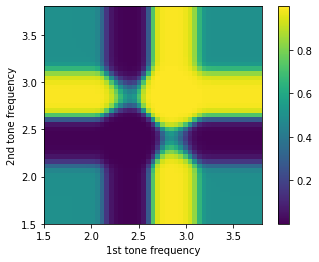

In [9]:
fig = plt.figure()
ax = fig.add_subplot(111)
colormap = ax.imshow(posterior, extent=[log_freq_percept[0], log_freq_percept[-1], \
                                        log_freq_percept[-1], log_freq_percept[0]])
ax.invert_yaxis()
cbar = plt.colorbar(colormap, ax=ax)
ax.set_xlabel('1st tone frequency')
ax.set_ylabel('2nd tone frequency')

In [7]:
"""
Three tones
Perceptual tones have a longer range than the experimental tones.
"""
log_freq_percept = np.arange(np.log10(expt_tones[0])-0.5, \
                             np.log10(expt_tones[-1])+0.5, 0.05) # array of possible perceptual tones

prior_dist_mixed_high, prior_dist_mixed_low, posterior = \
posterior_array(log_freq_percept, n_tones=3, p_back=0.2, p_low=0.5, \
                log_prior_low=log_freq_low, log_prior_high=log_freq_high) 

"""
Given the true tones, derive the noisy perceptual distribution and compute the correponding observer's behaviour
Decision rule - the behaviour is 1 if p(H|log T_{perc}) > 0.52 and 0 if p(H|log T_{perc}) < 0.48. 
Otherwise we assume that the observer being imperfect has a 0.5 probability of choosing high or low. 
Probability_high - probability the observer will choose high given the true tone, p(B_H|T)
"""
probability_high = np.zeros((len(trial_tones),1))
probability_bhigh = np.zeros((len(trial_tones),1))
behaviour = posterior >= 0.52
for i_post0 in range(posterior.shape[0]):
    for i_post1 in range(posterior.shape[1]):
        for i_post2 in range(posterior.shape[2]):
            if posterior[i_post0, i_post1, i_post2] < 0.52 and posterior[i_post0, i_post1, i_post2] > 0.48:
                behaviour[i_post0, i_post1, i_post2] = np.random.random() < 0.5
            
for i_stim in range(len(trial_tones)):
    input_array_0 = np.expand_dims(gaussian(log_freq_percept, mean = np.log10(trial_tones[i_stim][0]), \
                                            sigma = 0.1), axis = 1)
    input_array_1 = np.expand_dims(gaussian(log_freq_percept, mean = np.log10(trial_tones[i_stim][1]), \
                                            sigma = 0.1), axis = 1)
    input_array_2 = np.expand_dims(gaussian(log_freq_percept, mean = np.log10(trial_tones[i_stim][2]), \
                                            sigma = 0.1), axis = 1)
    input_array_mat = np.expand_dims(input_array_0@np.transpose(input_array_1),axis=2)@np.transpose(input_array_2)\
                                   #p(T1,T2..|H)     
    input_array_mat /= np.sum(input_array_mat)
    probability_bhigh[i_stim] = np.sum(np.multiply(behaviour, input_array_mat))
    probability_high[i_stim] = np.sum(np.multiply(posterior, input_array_mat))

"""
For sample experiment, we choose the observer's behaviour based on p(B_H|T).
If p(B_H|T) > 0.55, H = 1, if less than < 0.45, H = 0. Else it is a coin toss. 
"""
trial_behaviour =  probability_bhigh > 0.6
for i_prob in range(len(probability_bhigh)):
    if probability_bhigh[i_prob] > 0.4 and probability_bhigh[i_prob] < 0.6:
        trial_behaviour[i_prob] = np.random.random() < 0.5

In [10]:
# define mle function
def MLE(params):
    log_prior_low_mean, log_prior_low_sigma, log_prior_high_mean, log_prior_high_sigma, p_back = \
    params[0], params[1], params[2], params[3], params[4] # inputs are guesses at our parameters
    
    prior_low = gaussian(x=log_freq_percept, mean=log_prior_low_mean, sigma=log_prior_low_sigma)
    prior_high = gaussian(x=log_freq_percept, mean=log_prior_high_mean, sigma=log_prior_high_sigma)
    prior_dist_mixed_high = p_back*(1/len(log_freq_percept)) + (1-p_back)*prior_high #mixture model
    prior_dist_mixed_high /= prior_dist_mixed_high.sum() #normalizing
    prior_dist_mixed_high = np.expand_dims(prior_dist_mixed_high, axis = 1)
    prior_dist_mixed_low = p_back*(1/len(log_freq_percept)) + (1-p_back)*prior_low #mixture model
    prior_dist_mixed_low /= prior_dist_mixed_low.sum() #normalizing
    prior_dist_mixed_low = np.expand_dims(prior_dist_mixed_low, axis = 1)

    if len(trial_tones[0]) == 3:
        prior_tones_low = np.expand_dims(prior_dist_mixed_low@np.transpose\
                                         (prior_dist_mixed_low),axis=2)@np.transpose(prior_dist_mixed_low) \
        #p(T1,T2..|L) 
        prior_tones_high = np.expand_dims(prior_dist_mixed_high@np.transpose\
                                          (prior_dist_mixed_high),axis=2)@np.transpose(prior_dist_mixed_high) \
        #p(T1,T2..|H) 
        
    elif len(trial_tones[0]) == 2:
        prior_tones_low = prior_dist_mixed_low@np.transpose(prior_dist_mixed_low)
        #p(T1,T2..|L) 
        prior_tones_high = prior_dist_mixed_high@np.transpose(prior_dist_mixed_high)
        #p(T1,T2..|H) 
        
    elif len(trial_tones[0]) == 1:
        prior_tones_low = prior_dist_mixed_low
        prior_tones_high = prior_dist_mixed_high
    
    p_low = 0.5 
    normalizer = (1-p_low)*prior_tones_high + p_low*prior_tones_low #p(H)*p(T1,T2..|H) + p(L)*p(T1,T2..|L)
    posterior = prior_tones_high*(1-p_low)/normalizer  
    behaviour0 = posterior >= 0.52
    if len(trial_tones[0]) == 3:
        for i_post0 in range(posterior.shape[0]):
            for i_post1 in range(posterior.shape[1]):
                for i_post2 in range(posterior.shape[2]):
                    if posterior[i_post0, i_post1, i_post2] < 0.52 and posterior[i_post0, i_post1, i_post2] > 0.48:
                        behaviour0[i_post0, i_post1, i_post2] = np.random.random() < 0.5    
    elif len(trial_tones[0]) == 2:
        for i_post0 in range(posterior.shape[0]):
            for i_post1 in range(posterior.shape[1]):
                    if posterior[i_post0, i_post1] < 0.52 and posterior[i_post0, i_post1] > 0.48:
                        behaviour0[i_post0, i_post1] = np.random.random() < 0.5 
    elif len(trial_tones[0]) == 1:           
        for i_post in range(len(posterior)):
            if posterior[i_post] < 0.52 and posterior[i_post] > 0.48:
                behaviour0[i_post] = np.random.random() < 0.5
        
    neg_ll = 0; 
    probability_high = np.zeros((len(trial_tones),1))
    for i_trial in range(len(trial_tones)):
        if len(trial_tones[i_trial]) == 3: 
            input_array_0 = np.expand_dims(gaussian(log_freq_percept, mean = np.log10(trial_tones[i_trial][0]), \
                                            sigma = 0.1), axis = 1)
            input_array_1 = np.expand_dims(gaussian(log_freq_percept, mean = np.log10(trial_tones[i_trial][1]), \
                                            sigma = 0.1), axis = 1)
            input_array_2 = np.expand_dims(gaussian(log_freq_percept, mean = np.log10(trial_tones[i_trial][2]), \
                                            sigma = 0.1), axis = 1)
            input_array_mat = np.expand_dims(input_array_0@np.transpose\
                                             (input_array_1),axis=2)@np.transpose(input_array_2) #p(T1,T2..|H)     
            input_array_mat /= np.sum(input_array_mat)
            probability_high0 = np.sum(np.multiply(posterior, input_array_mat))
            
        elif len(trial_tones[i_trial]) == 2: 
            for i_post0 in range(posterior.shape[0]):
                for i_post1 in range(posterior.shape[1]):
                    if posterior[i_post0, i_post1] < 0.52 and posterior[i_post0, i_post1] > 0.48:
                        behaviour0[i_post0, i_post1] = np.random.random() < 0.5 
            input_array_0 = np.expand_dims(gaussian(log_freq_percept, mean = np.log10(trial_tones[i_trial][0]), \
                                            sigma = 0.1), axis = 1)
            input_array_1 = np.expand_dims(gaussian(log_freq_percept, mean = np.log10(trial_tones[i_trial][1]), \
                                            sigma = 0.1), axis = 1)
            input_array_mat = input_array_0@np.transpose(input_array_1) #p(T1,T2..|H)     
            input_array_mat /= np.sum(input_array_mat)
            probability_high0 = np.sum(np.multiply(behaviour0, input_array_mat))    
            
        elif len(trial_tones[i_trial]) == 1:
            for i_post in range(len(posterior)):
                if posterior[i_post] < 0.52 and posterior[i_post] > 0.48:
                    behaviour0[i_post] = np.random.random() < 0.5
            input_array = gaussian(log_freq_percept, mean = np.log10(trial_tones[i_trial][0]), sigma = 0.1)
            input_array /= np.sum(input_array)
            input_array = np.expand_dims(input_array, axis = 1)            
            probability_high0 = np.transpose(behaviour0)@input_array # np.transpose(behaviour0)@input_array
            probability_high[i_trial] = np.transpose(behaviour0)@input_array \
            # np.transpose(behaviour0)@input_array       
            
        if trial_behaviour[i_trial]:
            neg_ll += -np.log(probability_high0 + np.finfo(float).eps) # if high dist is chosen by observer
        else:
            neg_ll += -np.log(1 - probability_high0 + np.finfo(float).eps) # if low dist is chosen by observer
        if np.isnan(np.log(probability_high0 + 0.00001)) \
        or np.isinf(np.log(probability_high0 + 0.00001)) \
        or np.isnan(np.log(1 - probability_high0 + 0.00001)) \
        or np.isinf(np.log(1 - probability_high0 + 0.00001)):
            pdb.set_trace()        
    return(neg_ll)

In [11]:
guess_low_mean = np.arange(2,2.6,0.05); guess_low_sigma = np.arange(0.05,0.2,0.05)
guess_high_mean = np.arange(2.6,3.2,0.05); guess_high_sigma = np.arange(0.05,0.2,0.05)
guess_p_back = np.arange(0.05,1,0.05)
"""
Constraining guesses of means of low and high distributions based on observed behaviour in figure shown above. 
Currently estimating only means and p_back.
"""
neg_ll_array = np.zeros((len(guess_low_mean),len(guess_low_sigma),\
                         len(guess_high_mean),len(guess_high_sigma),len(guess_p_back)))
for lm in tqdm(range(len(guess_low_mean))):
    for ls in tqdm(range(len(guess_low_sigma)), leave=False, desc="Low sigma"):
        for hm in range(len(guess_high_mean)):
            for hs in range(len(guess_high_sigma)):
                for pb in range(len(guess_p_back)):
                    params = [guess_low_mean[lm], guess_low_sigma[ls], guess_high_mean[hm], \
                              guess_high_sigma[hs], guess_p_back[pb]]
                    # print(lm, hm, pb)
                    neg_ll_array[lm,ls,hm,hs,pb] = MLE(params)      

In [12]:
# Means and p_back corresponding to the least negative log likelihood value
idxs = np.where(neg_ll_array == np.amin(neg_ll_array)) 
guess_low_mean[idxs[0]], guess_low_sigma[idxs[1]],  guess_high_mean[idxs[2]], \
guess_high_sigma[idxs[3]], guess_p_back[idxs[4]]

(array([2.45]), array([0.1]), array([2.85]), array([0.15]), array([0.5]))